In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data -O 'homework.csv'

--2025-10-21 09:14:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘homework.csv’

homework.csv        100%[===================>]  78.98K  --.-KB/s    in 0.09s   

2025-10-21 09:14:23 (886 KB/s) - ‘homework.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('homework.csv')

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data Preparation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

for c in categorical:
    df[c] = df[c].fillna('NA')

for n in numerical:
    df[n] = df[n].fillna(0.0)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

In [9]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [10]:
from sklearn.metrics import roc_auc_score
scores = {}
for n in numerical:
    score = roc_auc_score(y_train, df_train[n])
    scores[n] = score    
sorted_items_desc = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_dict_desc = dict(sorted_items_desc)
sorted_dict_desc

{'number_of_courses_viewed': 0.7635680590007088,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176,
 'annual_income': 0.5519578313253012}

## Question 2: Training the model

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)
round(score,3)

/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.919

## Question 3: Precision and Recall

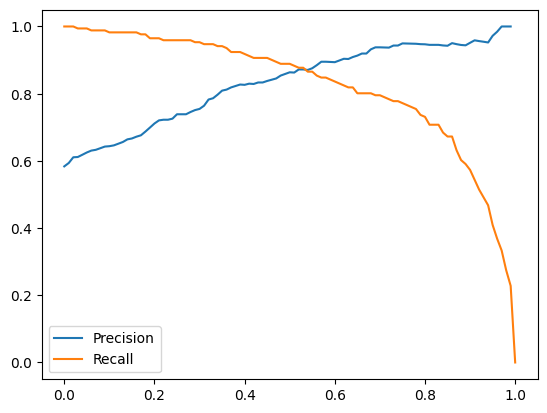

In [17]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)


plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [18]:
df_scores["precision_recall_difference"] = np.abs(df_scores["p"] - df_scores["r"])
min_value_pr_diff_idx = df_scores['precision_recall_difference'].idxmin()
threshold_at_min_diff_value = df_scores.loc[min_value_pr_diff_idx, 'threshold']
threshold_at_min_diff_value

np.float64(0.54)

## Question 4: F1 score

In [26]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = 2 * ( ( df_scores['p'] * df_scores['r'] ) / ( df_scores['p'] + df_scores['r'] ) )

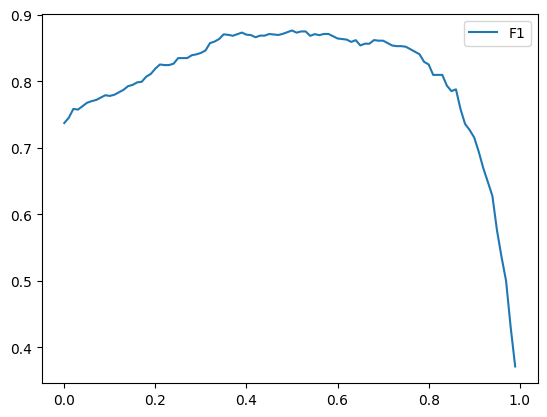

In [27]:
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

In [28]:
max_threshold = df_scores.loc[df_scores['f1'].idxmax()]['threshold']
max_threshold

np.float64(0.5)

## Question 5: 5-Fold CV

In [29]:
from sklearn.model_selection import KFold

In [30]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 545.0 kB/s eta 0:00:001m455.5 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [31]:
from tqdm.auto import tqdm

In [41]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [42]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [55]:
n_splits=5
C=1.0
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f' % np.std(scores))

0.036


## Question 6: Hyperparameter Tuning

In [64]:
n_splits=5
C_scores = []
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    C_scores.append({'C':C, 'mean':round(np.mean(scores),3), 'std':round(np.std(scores),3)})  
C_scores

  0%|          | 0/7 [00:00<?, ?it/s]

[{'C': 0.001, 'mean': np.float64(0.867), 'std': np.float64(0.029)},
 {'C': 0.01, 'mean': np.float64(0.831), 'std': np.float64(0.034)},
 {'C': 0.1, 'mean': np.float64(0.823), 'std': np.float64(0.035)},
 {'C': 0.5, 'mean': np.float64(0.822), 'std': np.float64(0.036)},
 {'C': 1, 'mean': np.float64(0.822), 'std': np.float64(0.036)},
 {'C': 5, 'mean': np.float64(0.822), 'std': np.float64(0.036)},
 {'C': 10, 'mean': np.float64(0.822), 'std': np.float64(0.036)}]

In [67]:
df_C = pd.DataFrame(C_scores)
C_best = df_C.loc[df_C['mean'].idxmax()]['C']
C_best

np.float64(0.001)